Цель данной работы - создать модель для определения мошеннических транзакций по кредитным картам, чтобы предотвратить несанкционированную оплату товаров/услуг с карт клиентов. В нашем распоряжении датасет с транзакциями клиентов европейских банков за 2 дня 2013 года. В датасете 284807 строк с и информацией о транзакциях, 492 из которых - мошеннические. Данные сильно не сбалансированны, объекты 1 класса (фрод) составляют 0,172% от всего датасета. Датасет содержит следующие признаки:

- числовые признаки, преобразованные с помощью метода главных компонент (PCA transformation).
- признак "Amount" - сумма транзакции.
- "Time" - время в секундах между данной транзакцией и первой транзакцией в датасете.

При разработке модели возникает проблема несбалансированности данных, так как соотношение мошеннических транзакций к общему количеству транзакций слишком мало. При использовании стандартных методов классификации в такой ситуации часто возникает проблема, что при уменьшении общей ошибки классификатор полностью относит интересуемый класс к шуму. В таком случае возникает парадокс точности, когда показатели точности отражают только распределение базового класса, игнорируя при этом интересуемый класс нелегитимных транзакций. Таким образом появляется потребность в решении проблемы несбалансированности.

План работ:

1) Загрузить данные и осуществить первичный осмотр;

2) При необходимости сделать предобработку данных:
- проверить корректность типов данных, в случае необходимости поменять тип данных;
- проверить на пропуски и дубликаты. Обработать в случае необходимости или объяснить метод обработки (удаление, замена на другое значение или оставить как есть).

3) Провести исследовательский анализ данных.

4) Провести корреляционный анализ данных. В случае необходимости добавить или удалить признаки.

5) Подготовить данные для моделей. Очень важный момент в данной задаче - корректно подойти к проблеме несбалансированности данных, так как соотношение мошеннических транзакций к общему количеству транзакций слишком мало.

6) Обучить модели, подобрать гиперпараметры, выбрать метрику для оценки качества моделей. Аргументировать выбор метрики.

7) Построить cofusion matrics для обученных моделей, выбрать лучшую модель.

8) Для лучшей модели сделать прогноз на тестовой выборке и построить Area Under the Precision-Recall Curve (AUPRC). Оценить качество работы модели на тестовой выборке.

## Импорт библиотек

In [2]:
!pip install phik -q
!pip install category_encoders -q

In [3]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 3.7 MB/s eta 0:00:00


In [4]:
import xgboost

In [5]:
!pip install imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 2.2 MB/s eta 0:00:00


In [6]:
!pip install lazypredict

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 15.6 MB/s eta 0:00:00


In [7]:
!pip install lightgbm

In [8]:
import lazypredict
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phik
import seaborn as sns
import xgboost as xgb

from category_encoders import MEstimateEncoder
from lightgbm import LGBMRegressor
#from catboost import CatBoostRegressor
from lazypredict.Supervised import LazyClassifier
from imblearn.over_sampling import ADASYN
from phik import resources, report
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.semi_supervised import LabelSpreading, LabelPropagation
from sklearn.ensemble import VotingClassifier


## Шаг 1. Загрузка данных

Перед загрузкой файла credircard.csv загружаем его на компьютер:
https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud?select=creditcard.csv

In [9]:
# из библиотеки google.colab импортируем класс files
from google.colab import files

# создаем объект этого класса, применяем метод .upload()
uploaded = files.upload()

Saving creditcard.csv to creditcard.csv


In [10]:
# посмотрим на содержимое переменной uploaded
uploaded

In [11]:
# импортируем модуль os
import os

# выводим пути к папкам (dirpath) и наименования файлов (filenames) и после этого
for dirpath, _, filenames in os.walk('/content/'):

  # во вложенном цикле проходимся по названиям файлов
  for filename in filenames:

    # и соединяем путь до папок и входящие в эти папки файлы
    # с помощью метода path.join()
    print(os.path.join(dirpath, filename))

In [50]:
data = pd.read_csv('/content/creditcard.csv')

In [51]:
#Смотрим первые строки:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.00,-1.36,-0.07,2.54,1.38,-0.34,0.46,0.24,0.10,0.36,...,-0.02,0.28,-0.11,0.07,0.13,-0.19,0.13,-0.02,149.62,0
1,0.00,1.19,0.27,0.17,0.45,0.06,-0.08,-0.08,0.09,-0.26,...,-0.23,-0.64,0.10,-0.34,0.17,0.13,-0.01,0.01,2.69,0
2,1.00,-1.36,-1.34,1.77,0.38,-0.50,1.80,0.79,0.25,-1.51,...,0.25,0.77,0.91,-0.69,-0.33,-0.14,-0.06,-0.06,378.66,0
3,1.00,-0.97,-0.19,1.79,-0.86,-0.01,1.25,0.24,0.38,-1.39,...,-0.11,0.01,-0.19,-1.18,0.65,-0.22,0.06,0.06,123.50,0
4,2.00,-1.16,0.88,1.55,0.40,-0.41,0.10,0.59,-0.27,0.82,...,-0.01,0.80,-0.14,0.14,-0.21,0.50,0.22,0.22,69.99,0


In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [ ]:
data.describe()

Признак Время (Time) здесь числовой, именно в этой задаче нуже формат НЕ DateTime, а число, обозачающее количество секунд с первой операции.

Признак Сумма (Amount) - сумма транзакции. Признак Класс (Class) является целевым. Это бинарный признак, который может принимать значения 1 (True, операция является мошеннической) и 0 (False, операция НЕ является мошеннической). На шаге предобработки поменяем тип на boollean.

Значения столбцов V1 - V28 были преобразованы с помощью метода главных компонент (PCA transformation), мы не можем итерпретировать значения этих столбцов, т к их исходные данные преобразованы из соображений конфиденциальности. В дальнейшем можем проанализировать только корреляцию этих признаков в целевым и друг с другом. Провести исследовательский анализ этих столбцов тоже невозможно из-за незнания того,что за ними стоИт. C помощью метода describe() мы увидели, что кодированные признаки принимают значения от ~ -7 до ~ +9,38 (минимальные и максимальные значения в этих столбцах).

Чтобы привести данные к единому масштабу, нужно стандартизировать все числовые столбцы, включая V1-V28, т к значения этих колонок выходят за пределы диапазона [-1, 1].

***Вывод после первичного осмотра данных:***

***1)*** Нужно перевести формат данных в столбце с целевым признаком Class в booleean.

***2)*** Нужно стандартизировать числовые столбцы с помощью StandardScaler() после исследовательского анализа данных.

##Шаг 2. Предобработка данных.

Поменяем тип данных в столбце с целевым признаком.

In [53]:
data['Class'] = data['Class'].map({1: True, 0: False})

In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Тип данных поменяли.

Проверим датасет на пропуски.

In [55]:
data.isna().sum()

,0
Time,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0


Пропусков нет. Проверим на дубликаты. Нужно понимать, что в теории полные дубликаты могут быть, т к операции по разным картам могут совершаться в одно и то же время с одной и той же суммой. Но дубликаты в строках с целевым классом 0 (легитимные операции) могут усложнять обучения модели, т к эти данные и без дубликатов представлены в подавляющем большинстве, и дубликаты легитимных операций в случае их наличия нужно удалить. Дубликаты в строках с мошенническими операции (Class = 1) удалять не нужно, т к этих операций итак очень мало, и каждая из них представляет ценность для анализа и обучения модели.

In [56]:
data.duplicated().sum()

1081

Видим 1081 дубликат, это 0,4% датасета. Не очень много для мажоритарного класса, но для минорного класса ощутимо. Проверим, к каким классам относятся дубликаты.

In [57]:
data_major = data[data['Class'] == 0]
data_major.duplicated().sum()

1062

Видим, что не все дубликаты принадлежат к классу легитимных операций. 1062 дубликата из 1081 это легитимные операции, 19 строк из дубликатов - это мошеннические операции.

In [58]:
data_minor =  data[data['Class'] == 1]
#проверим, сопадает ли сумма строк в data_major и data_minor с
#размером исходного датасета
data_shape = len(data_major) + len(data_minor)
print(data_shape)

284807


Удалим дубликаты из легитимных операций (data_major)

In [59]:
data_major = data_major.drop_duplicates()

Посмотрим дулбикаты в минорном датасете (мошеннические операции)

In [60]:
display(data_minor[data_minor.duplicated ()])

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
102442,68207.00,-13.19,12.79,-9.91,3.32,-4.80,5.76,-18.75,-37.35,-0.39,...,27.20,-8.89,5.30,-0.64,0.26,-0.11,1.27,0.94,1.00,True
102443,68207.00,-13.19,12.79,-9.91,3.32,-4.80,5.76,-18.75,-37.35,-0.39,...,27.20,-8.89,5.30,-0.64,0.26,-0.11,1.27,0.94,1.00,True
102444,68207.00,-13.19,12.79,-9.91,3.32,-4.80,5.76,-18.75,-37.35,-0.39,...,27.20,-8.89,5.30,-0.64,0.26,-0.11,1.27,0.94,1.00,True
102445,68207.00,-13.19,12.79,-9.91,3.32,-4.80,5.76,-18.75,-37.35,-0.39,...,27.20,-8.89,5.30,-0.64,0.26,-0.11,1.27,0.94,1.00,True
102446,68207.00,-13.19,12.79,-9.91,3.32,-4.80,5.76,-18.75,-37.35,-0.39,...,27.20,-8.89,5.30,-0.64,0.26,-0.11,1.27,0.94,1.00,True
141258,84204.00,-0.94,3.46,-6.45,4.93,-2.23,-2.29,-5.70,1.34,-4.32,...,1.07,-0.52,-0.32,-0.41,0.91,1.17,1.37,0.73,0.00,True
141260,84204.00,-1.93,1.83,-7.02,5.35,-2.74,-2.11,-5.02,1.21,-4.38,...,1.38,-0.79,-0.77,-0.38,0.72,1.11,1.28,0.82,512.25,True
143334,85285.00,-7.03,3.42,-9.53,5.27,-4.02,-2.87,-6.99,3.79,-4.62,...,1.10,-0.54,0.04,-0.36,0.35,1.04,1.36,-0.27,0.00,True
143336,85285.00,-6.71,3.92,-9.75,5.15,-5.15,-2.10,-5.94,3.58,-4.68,...,0.95,-0.45,0.13,-0.34,0.39,1.08,1.65,-0.39,252.92,True
150661,93853.00,-6.19,7.10,-13.03,8.01,-7.89,-3.97,-12.23,4.97,-4.25,...,2.50,0.48,0.48,0.36,-0.29,-0.20,-0.20,0.40,44.90,True


Видим, что не во всех дубликатах из таблицы с мошенническими операциями одинаковые суммы. Есть строки с полным дублированием значений всех столбцов, а есть строки, где значения всех столбцов, кроме суммы операции, одинаковые, а суммы разные. Поскольку мошенические операции могут быть похожи и могут осуществляться в одно и то же время с нескольких карт, и поскольку в представленном датасете операций класса 1 немного, удалять дубликаты из таблицы с минорным классом НЕ будем. Каждая операция может представлять ценность для анализа и обучения модели.

Объединим датасеты с мажорным классом (очищенным от дубликатов) и с минорным классом.

In [61]:
data = pd.concat([data_major, data_minor], axis = 0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 283745 entries, 0 to 281674
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    283745 non-null  float64
 1   V1      283745 non-null  float64
 2   V2      283745 non-null  float64
 3   V3      283745 non-null  float64
 4   V4      283745 non-null  float64
 5   V5      283745 non-null  float64
 6   V6      283745 non-null  float64
 7   V7      283745 non-null  float64
 8   V8      283745 non-null  float64
 9   V9      283745 non-null  float64
 10  V10     283745 non-null  float64
 11  V11     283745 non-null  float64
 12  V12     283745 non-null  float64
 13  V13     283745 non-null  float64
 14  V14     283745 non-null  float64
 15  V15     283745 non-null  float64
 16  V16     283745 non-null  float64
 17  V17     283745 non-null  float64
 18  V18     283745 non-null  float64
 19  V19     283745 non-null  float64
 20  V20     283745 non-null  float64
 21  V21     283745 

In [62]:
data.duplicated().sum()

19

Мы удалили 1062 дубликата из строк с легитимными операциями и оставили 19 строк-дубликатов с мошенническими операциями.

***Выводы после предобработки данных:***

***1)*** Перевели тип данных в столбце с бинарным целевым признаков в boollean.

***2)*** Удалили 1062 дубликатов в строках с легитимными операциями, 19 дубликатов в строках с мошенническими операциями оставили.

##Шаг 3. Исследовательский анализ данных.

Посмотрим на дисбаланс классов.

Text(0, 0.5, 'Count')

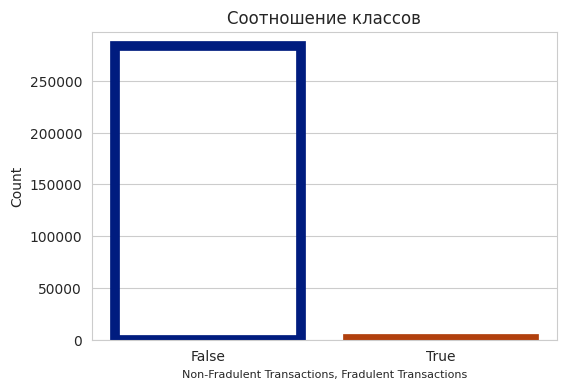

In [63]:
plt.figure(figsize = (6, 4))
sns.countplot(
    x = 'Class',
    data = data,
    facecolor = (0,0,0,0),
    linewidth = 7,
    edgecolor = sns.color_palette('dark', 2))
plt.title('Соотношение классов')
plt.xlabel('Non-Fradulent Transactions, Fradulent Transactions', fontsize = 8)
plt.ylabel('Count')

Для балансировки данных наибольшей популярностью пользуется алгоритм SMOTE, который синтезирует новые экземпляры меньшинства между существующими экземплярами миноритарного класса. Недостаток данного подхода заключается в том, что «вслепую» увеличивает плотность объектами в области слабо представленного класса. В случае, если миноритарные объекты равномерно распределены среди мажоритарных и имеют низкую плотность, алгоритм SMOTE способен только сильнее перемешать классы.

Увеличение соотношения класса нелегитимных транзакций к классу легитимных требует больших вычислительных ресурсов, а также «засоряет» нелегитимный класс не всегда уместными «дублями». Это приведет к переобучению, а также к увеличению числа ошибок первого рода (False Positive, когда объект класса ноль ошибочно классифицируется как объект 1 класса, т е легитимную операцию классифицируют как мошенническую).

Уменьшение мажоритарного класса и, как следствие, соотношения класса легитимных транзакций, ведет к потере информации о легитимных операциях. Это тоже может привести к переобучению, а также к увеличению числа ошибок второго рода (False Negative, когда мошеннические транзакции ошибочно интерпретируются как легитимные). В данной задаче ошибки второго рода (False Negative) недопустимы: ошибка пропустить мошенническую транзакцию стОит дороже, чем ошибка квалифицировать легитимную операцию как мошенническую. В нашем случае стоИт задача свести в нулю или к минимально возможному порогу ошибки False Negative и максимизировать метрику recall, которая показывает, смогла ли модель классификации присвоить класс 1 всем объектам этого класса.

В обоих случаях, если искуственно генерировать объекты минорного класса или уменьшать мажорные объекты, модель может "думать", что, например, на 2000 транзакций приходится не одна мошеническая, а 100 или 200, и это может привести к не корректным предсказаниям. Я бы попробовала обойтись другими методами, например, присваивать минорному классу бОльший вес (class_weight) и использовать лучшие для таких задач модели градиентного бустинга.

Посмотрим распределение транзакций во времени. Time – это количество секунд, прошедших между рассматриваемой и первой транзакцией в наборе данных.

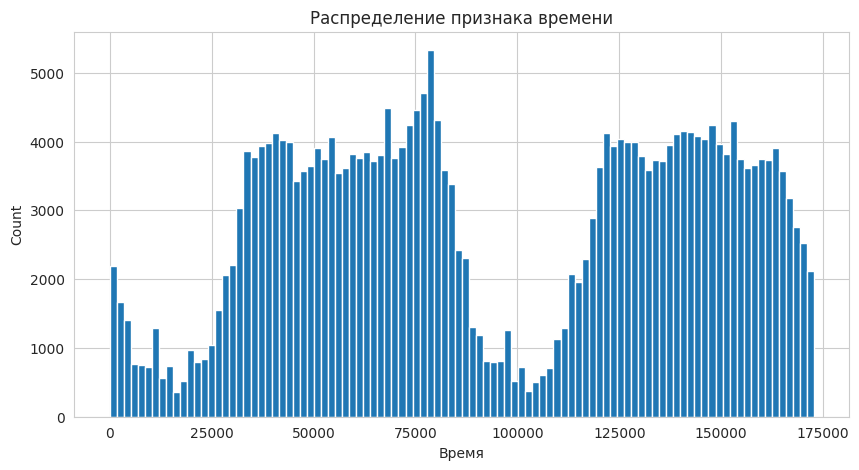

In [64]:
plt.figure(figsize = (10, 5))
plt.hist(data['Time'], bins = 100)
plt.title('Распределение признака времени')
plt.xlabel('Время', fontsize = 10)
plt.ylabel('Count')
plt.show;

Сложно делать анализ временного признака в секундах, далее сделаем анализ в часах, предварительно создадим новый признак часа, в который произошла транзакция.

Посмотрим распределение признака суммы транзакции.

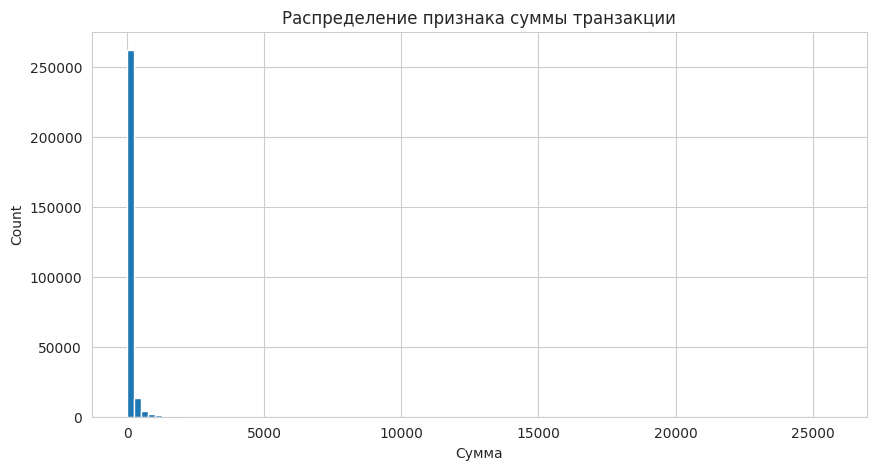

In [65]:
plt.figure(figsize = (10, 5))
plt.hist(data['Amount'], bins = 100)
plt.title('Распределение признака суммы транзакции')
plt.xlabel('Сумма', fontsize = 10)
plt.ylabel('Count')
plt.show;

По графику видно, что в датасете присутствуют аномалии. Посмотрим статистику по этому признаку в мажорном и минорном датасетах. Если аномалии есть в мажорном датасете, их удаляем, если в минорном - оставляем, т к мошеннические операции могут отличаться от легитимным в том числе суммой.

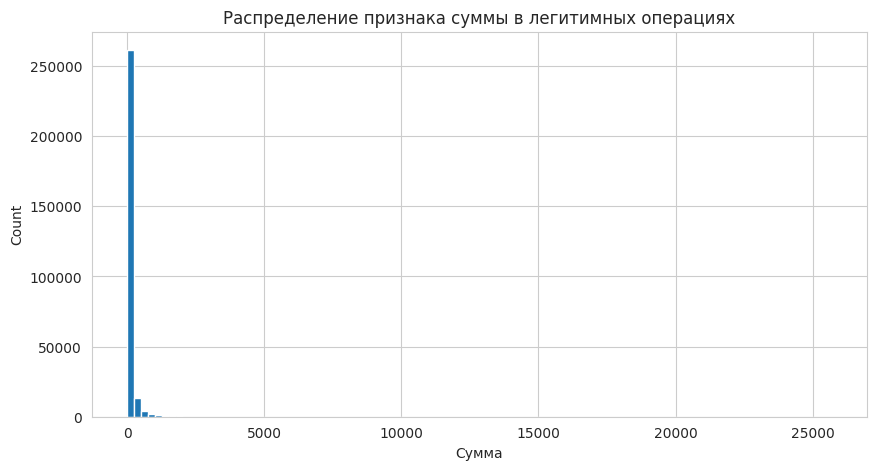

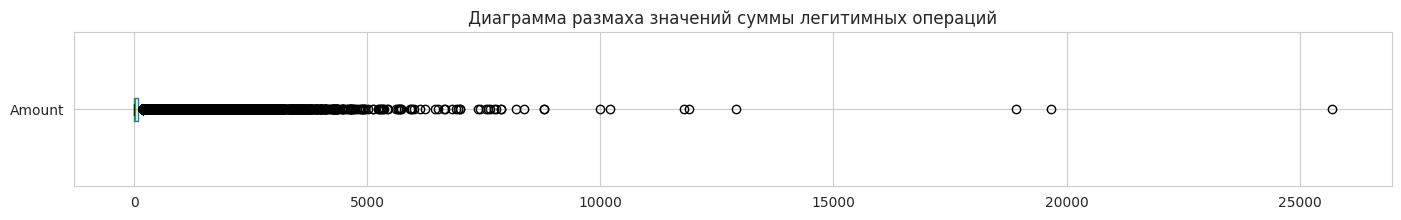

Статистика: count   283745.00
mean        88.47
std        250.39
min          0.00
25%          5.60
50%         22.00
75%         77.52
max      25691.16
Name: Amount, dtype: float64


In [66]:
plt.figure(figsize = (10, 5))
plt.hist(data_major['Amount'], bins = 100)
plt.title('Распределение признака суммы в легитимных операциях')
plt.xlabel('Сумма', fontsize = 10)
plt.ylabel('Count')
plt.show;

fig, ax = plt.subplots(figsize = (17,2))
ax = data[['Amount']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений суммы легитимных операций')
plt.show();

print('Статистика:', data['Amount'].describe())

Видим много выбросов и аномалии в легитимных транзакциях. Посмотрим 99% квантиль.

In [67]:
data_major['Amount'].quantile([0.99])

,Amount
0.99,1018.06


99% квантиль лежит выше трех стандартных отклонений (250*3) от среднего значения. Перед тем, как решать, значения выше какого порога удалять, посмотрим распределение признака суммы в мошеннических операциях.

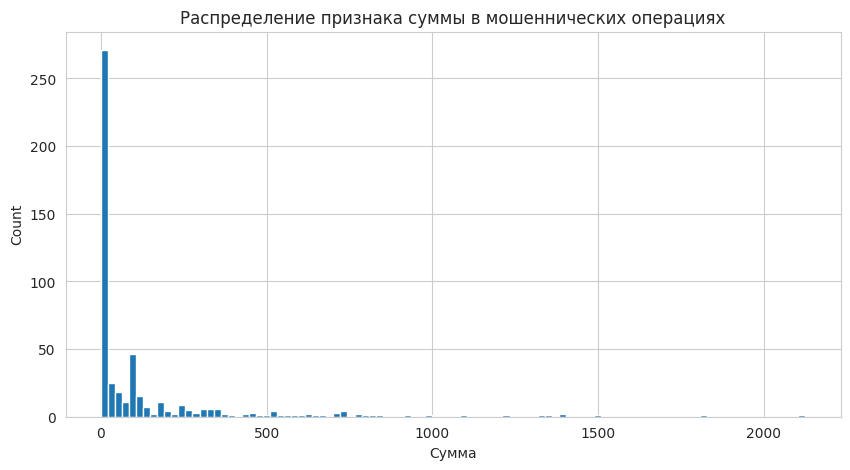

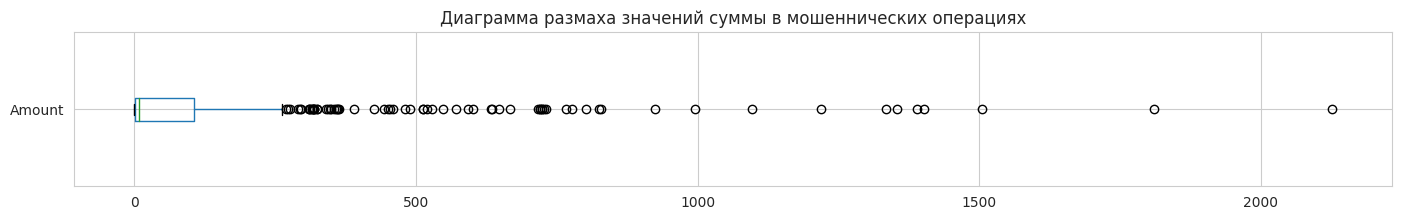

Статистика: count    492.00
mean     122.21
std      256.68
min        0.00
25%        1.00
50%        9.25
75%      105.89
max     2125.87
Name: Amount, dtype: float64


In [68]:
plt.figure(figsize = (10, 5))
plt.hist(data_minor['Amount'], bins = 100)
plt.title('Распределение признака суммы в мошеннических операциях')
plt.xlabel('Сумма', fontsize = 10)
plt.ylabel('Count')
plt.show;

fig, ax = plt.subplots(figsize = (17,2))
ax = data_minor[['Amount']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений суммы в мошеннических операциях')
plt.show();

print('Статистика:', data_minor['Amount'].describe())

Видим, что в мошеннических операциях признак суммы "разбросан" не так сильно: максимальная сумма транзакции равна 2125 ден.ед., в то время как в легитимных операциях максимальная сумма равна 25691 ден.ед. При этом стандартное отклонение у обоих классов операций почти одинаковое: 250 у легитимных и 256 у мошеннических. То есть для тех и других транзакций стандартное отклонение оодинаковое, но в легитимных операциях больше аномалий в суммах транзакций. Удалим аномалии в мажорном датасете, значения суммы которых выше суммы максимальной мошеннической транзакции.

In [69]:
#Посмотрим 99,8% квантиль.
data_major['Amount'].quantile([0.998])

,Amount
1.00,2201.71


Удалим 0,2% легитимных транзакций, значения сумм которых выходят за пределы 99,8% квантиля.

In [70]:
data_major = data_major[data_major['Amount'] <= 2201.7]

Посмотрим распределение признака суммы легитимных транзакций после удаления аномалий.

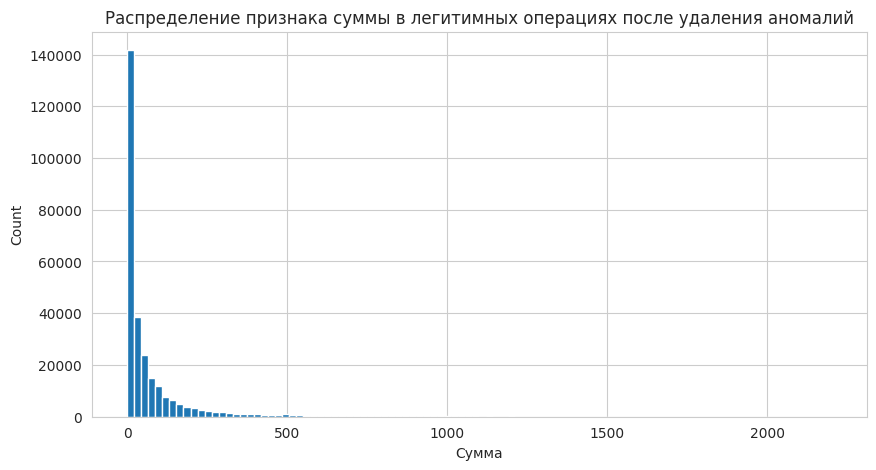

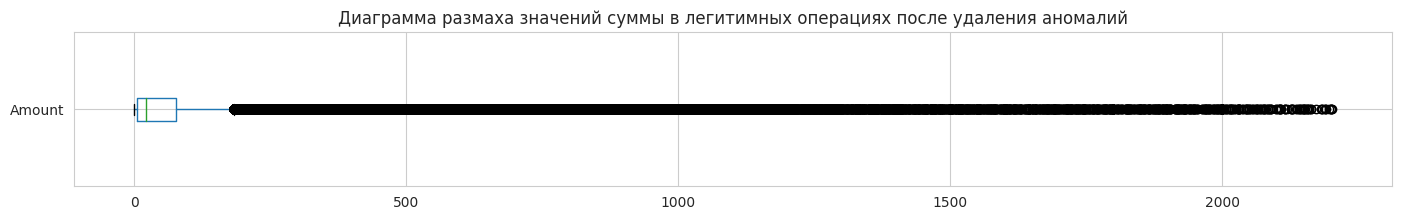

Статистика: count   282686.00
mean        81.51
std        177.61
min          0.00
25%          5.58
50%         21.99
75%         76.65
max       2201.43
Name: Amount, dtype: float64


In [71]:
plt.figure(figsize = (10, 5))
plt.hist(data_major['Amount'], bins = 100)
plt.title('Распределение признака суммы в легитимных операциях после удаления аномалий')
plt.xlabel('Сумма', fontsize = 10)
plt.ylabel('Count')
plt.show;

fig, ax = plt.subplots(figsize = (17,2))
ax = data_major[['Amount']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений суммы в легитимных операциях после удаления аномалий')
plt.show();

print('Статистика:', data_major['Amount'].describe())

Посмотрим распределение признака времени в обоих датасетах, предварительно введем столбец с признаком часа для удобства анализа.

In [72]:
data_major['Hour'] = data_major['Time'].apply(lambda x: np.ceil(float(x)/3600)%24)
data_major[200000:200005]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Hour
201506,133908.00,1.87,-0.69,-0.64,-0.04,-0.35,0.36,-0.67,0.14,1.17,...,0.77,0.04,0.34,-0.12,0.09,-0.00,-0.04,69.95,False,14.00
201507,133910.00,-1.58,1.40,-3.60,-0.28,-0.28,-0.75,1.57,0.73,-0.78,...,1.85,0.33,0.80,-0.87,-0.16,0.69,0.01,221.00,False,14.00
201508,133910.00,1.87,-2.03,-2.16,-1.95,-0.10,1.09,-0.82,0.29,-1.70,...,-0.47,0.18,-1.04,-0.45,-0.24,-0.03,-0.05,201.00,False,14.00
201509,133910.00,-1.30,-0.67,-1.12,-0.89,-0.14,-0.09,3.37,-0.45,-0.17,...,0.40,1.06,0.54,0.42,-0.64,0.20,0.29,567.47,False,14.00
201510,133912.00,0.11,0.97,-0.36,-0.42,0.72,-1.31,1.14,-0.28,-0.08,...,0.87,-0.25,-0.13,-0.02,-0.17,0.07,0.07,21.78,False,14.00


In [73]:
data_minor['Hour'] = data_minor['Time'].apply(lambda x: np.ceil(float(x)/3600)%24)
data_major[200000:200005]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Hour
201506,133908.00,1.87,-0.69,-0.64,-0.04,-0.35,0.36,-0.67,0.14,1.17,...,0.77,0.04,0.34,-0.12,0.09,-0.00,-0.04,69.95,False,14.00
201507,133910.00,-1.58,1.40,-3.60,-0.28,-0.28,-0.75,1.57,0.73,-0.78,...,1.85,0.33,0.80,-0.87,-0.16,0.69,0.01,221.00,False,14.00
201508,133910.00,1.87,-2.03,-2.16,-1.95,-0.10,1.09,-0.82,0.29,-1.70,...,-0.47,0.18,-1.04,-0.45,-0.24,-0.03,-0.05,201.00,False,14.00
201509,133910.00,-1.30,-0.67,-1.12,-0.89,-0.14,-0.09,3.37,-0.45,-0.17,...,0.40,1.06,0.54,0.42,-0.64,0.20,0.29,567.47,False,14.00
201510,133912.00,0.11,0.97,-0.36,-0.42,0.72,-1.31,1.14,-0.28,-0.08,...,0.87,-0.25,-0.13,-0.02,-0.17,0.07,0.07,21.78,False,14.00


Посмотрим распределение легитимных и мошеннических транзакций во времени.

Text(0.5, 1.0, 'Мошеннические транзакции')

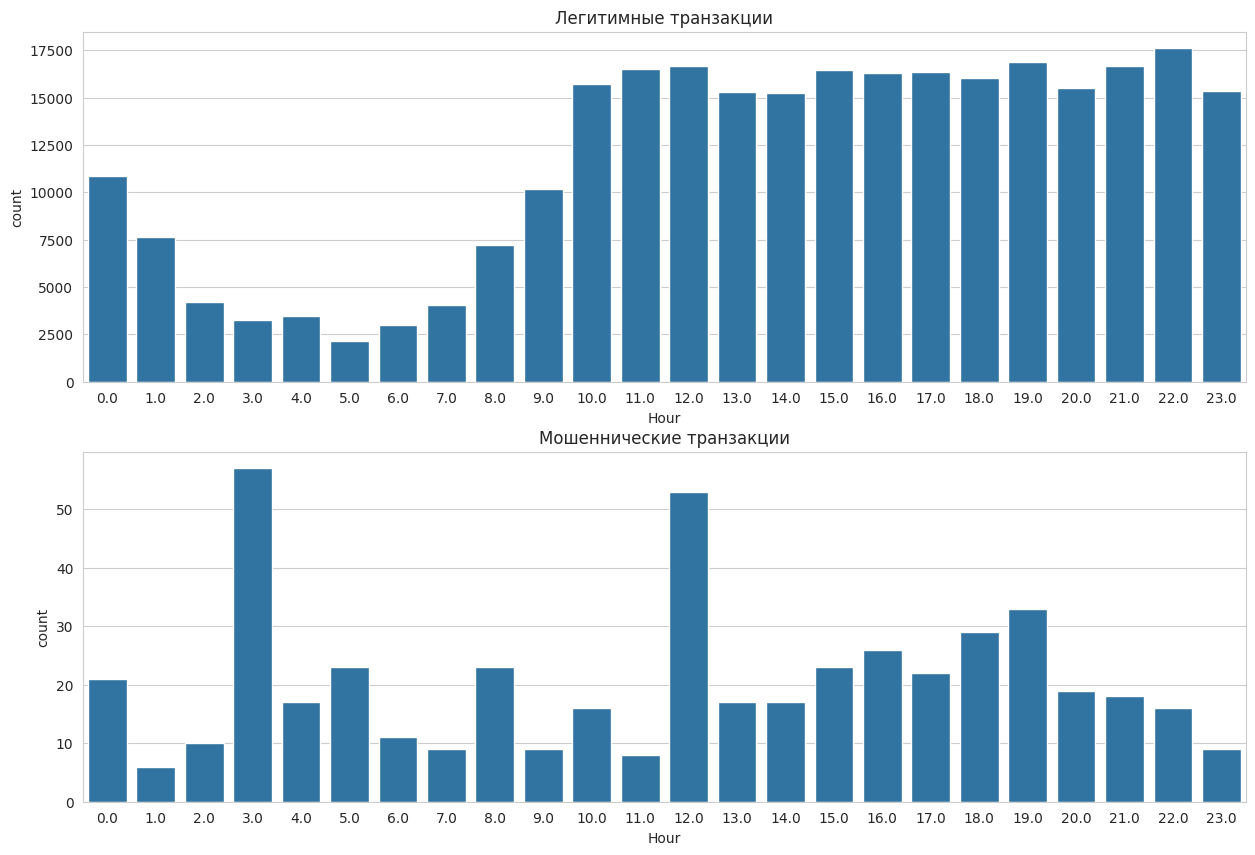

In [74]:
fig, axes = plt.subplots(2, 1, figsize = (15, 10))

sns.countplot(
    x = 'Hour',
    data = data_major,
    ax = axes[0])
axes[0].set_title('Легитимные транзакции')

sns.countplot(
    x = 'Hour',
    data = data_minor,
    ax = axes[1])
axes[1].set_title('Мошеннические транзакции')

Видим разницу между распределением операций во времени: легитимных транзакций ощутимо меньше с 0 до 10 часов (скорее всего, отсчет совпадает с временем суток), т е ночьюи ранним утром легитимных операций совершается меньше, что логично: ночью нормальные люди обычно спят.

Мошеннические транзакции имеют 2 пика: в 3 часа ночи и в 12 часов дня.

Разница в распределении времени в часах в разных классах ощутима, поэтому имеет смысл оставить признак часа. Объединим 2 датасета с новым признаком.

In [75]:
data = pd.concat([data_major, data_minor], axis = 0)
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Hour
0,0.00,-1.36,-0.07,2.54,1.38,-0.34,0.46,0.24,0.10,0.36,...,0.28,-0.11,0.07,0.13,-0.19,0.13,-0.02,149.62,False,0.00
1,0.00,1.19,0.27,0.17,0.45,0.06,-0.08,-0.08,0.09,-0.26,...,-0.64,0.10,-0.34,0.17,0.13,-0.01,0.01,2.69,False,0.00
2,1.00,-1.36,-1.34,1.77,0.38,-0.50,1.80,0.79,0.25,-1.51,...,0.77,0.91,-0.69,-0.33,-0.14,-0.06,-0.06,378.66,False,1.00
3,1.00,-0.97,-0.19,1.79,-0.86,-0.01,1.25,0.24,0.38,-1.39,...,0.01,-0.19,-1.18,0.65,-0.22,0.06,0.06,123.50,False,1.00
4,2.00,-1.16,0.88,1.55,0.40,-0.41,0.10,0.59,-0.27,0.82,...,0.80,-0.14,0.14,-0.21,0.50,0.22,0.22,69.99,False,1.00


***Выводы по исследовательскому анализу данных:***

***1)*** Имеет место сильный дисбаланс, что нормально и характерно для такого типа данных: мошеннические операции составляют 0,173% отвсех данных (492 строки). При подготовке данных для обучения модели нужно будет принять меры для того, чтобы из-за дисбаланса не искажался прогноз.

***2)*** Имеет место большой разброс сумм легитимных и мошеннических транзакций: средние медианные значения составляют  22 ден.ед (легитимные) и 9 ден.ед (мошеннические), стандартные отклонения почти одинаковые: 256 и 250 ден.ед. соответственно. Аномалий в легитимных операциях больше, мы удалили 0,2% легитимных транзакций, сумма которых была выше максимальной суммы мошеннических операций (транзакции выше 2200 ден.ед удалили).

***3)*** Ввели новый признак часа операции, посмотрели распределение операций по этому признаку. Легитимных операций ощутимо меньше ночью с 0 до 10 часов утра. Для мошеннических операци самые "популярные" часы - 3 часа ночи и 12 часов дня.

##Шаг 4. Корреляционный анализ

Поскольку зависимость между почти всеми входными признаками и целевым не линейная, построим матрицу корреляции Phik.

In [76]:
data_phik = data[['Class', 'Amount', 'Time', 'Hour', 'V1', 'V2', 'V3',\
                  'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',\
                  'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18',\
                  'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25',\
                  'V26', 'V27', 'V28']]
corr_matrix_data = data_phik.phik_matrix(
    interval_cols = ['Amount', 'Time', 'Hour', 'V1', 'V2', 'V3',\
                  'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',\
                  'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18',\
                  'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25',\
                  'V26', 'V27', 'V28'])

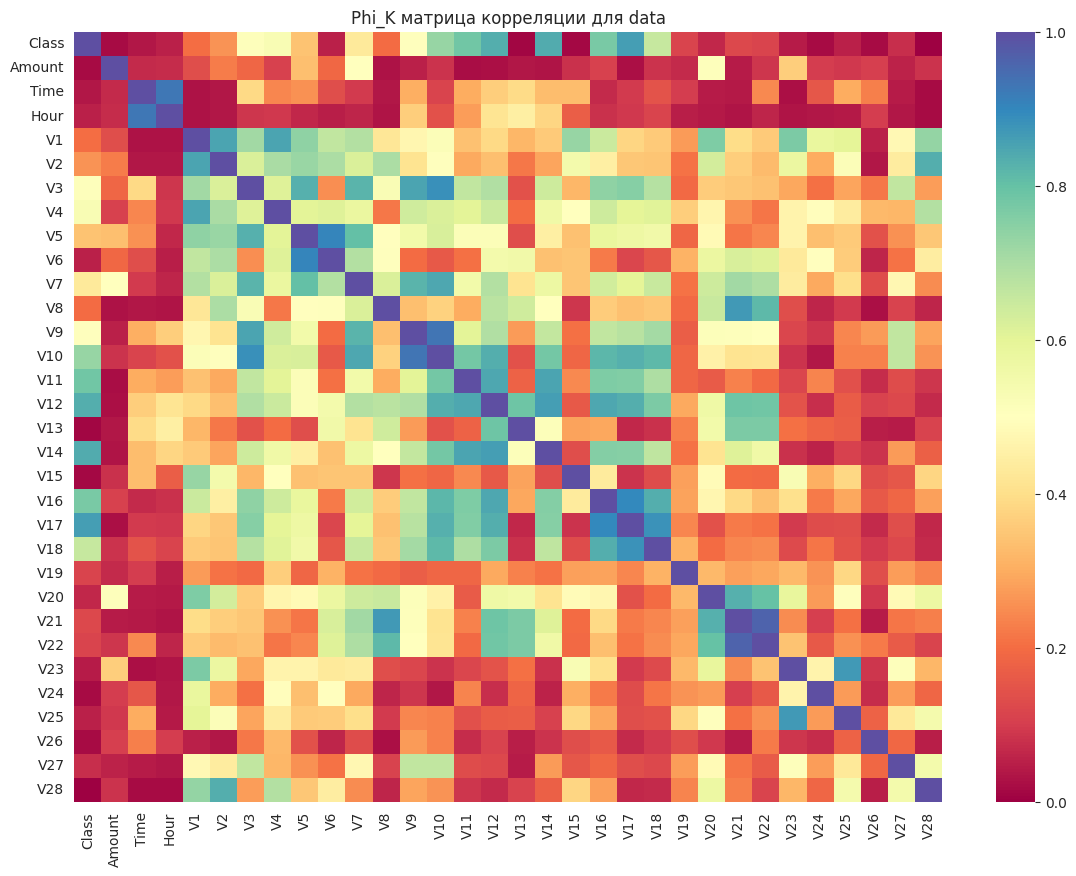

In [77]:
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix_data, cmap='Spectral')
plt.title('Phi_K матрица корреляции для data')
plt.show()

Видим, что на целевой признак больше всего влияют V10-V18, почти отсутствует корреляция у V19-V22, меньше всего - V23-V28. Ожидаемо высокая коррляция у признаков Time и Hour, т к второй признак выведен из первого. Признак Time уберем, т к по нему сложнее анализировать зависимость с таргетом: на гистограмме признака Hour были четко видны часы активности мошенников и часы, когда легитимных операций совершалось ощутимо меньше. Признак Hour оставим, тк несмотря на слабую корреляцию с целевым, на графиках была видна разница в рспределении этого признака у легитимных и мошеннических операций. Признак суммы так же коррелирует с таргетом слабо, и распределение этого признака у мошеннических и легитимных операциях выглядит одинаково. Чтобы снизить нагрузку на вычислительные ресурсы, признак суммы тоже можно убрать.

Перед тем как решать, что делать с признаками V23-V28, посмотрим разницу в распределении признаков у мажорного и минорного классов. Если распределение признака у разных классов одинаковое или похожее, будем удалять эти признаки.

<Figure size 640x480 with 0 Axes>

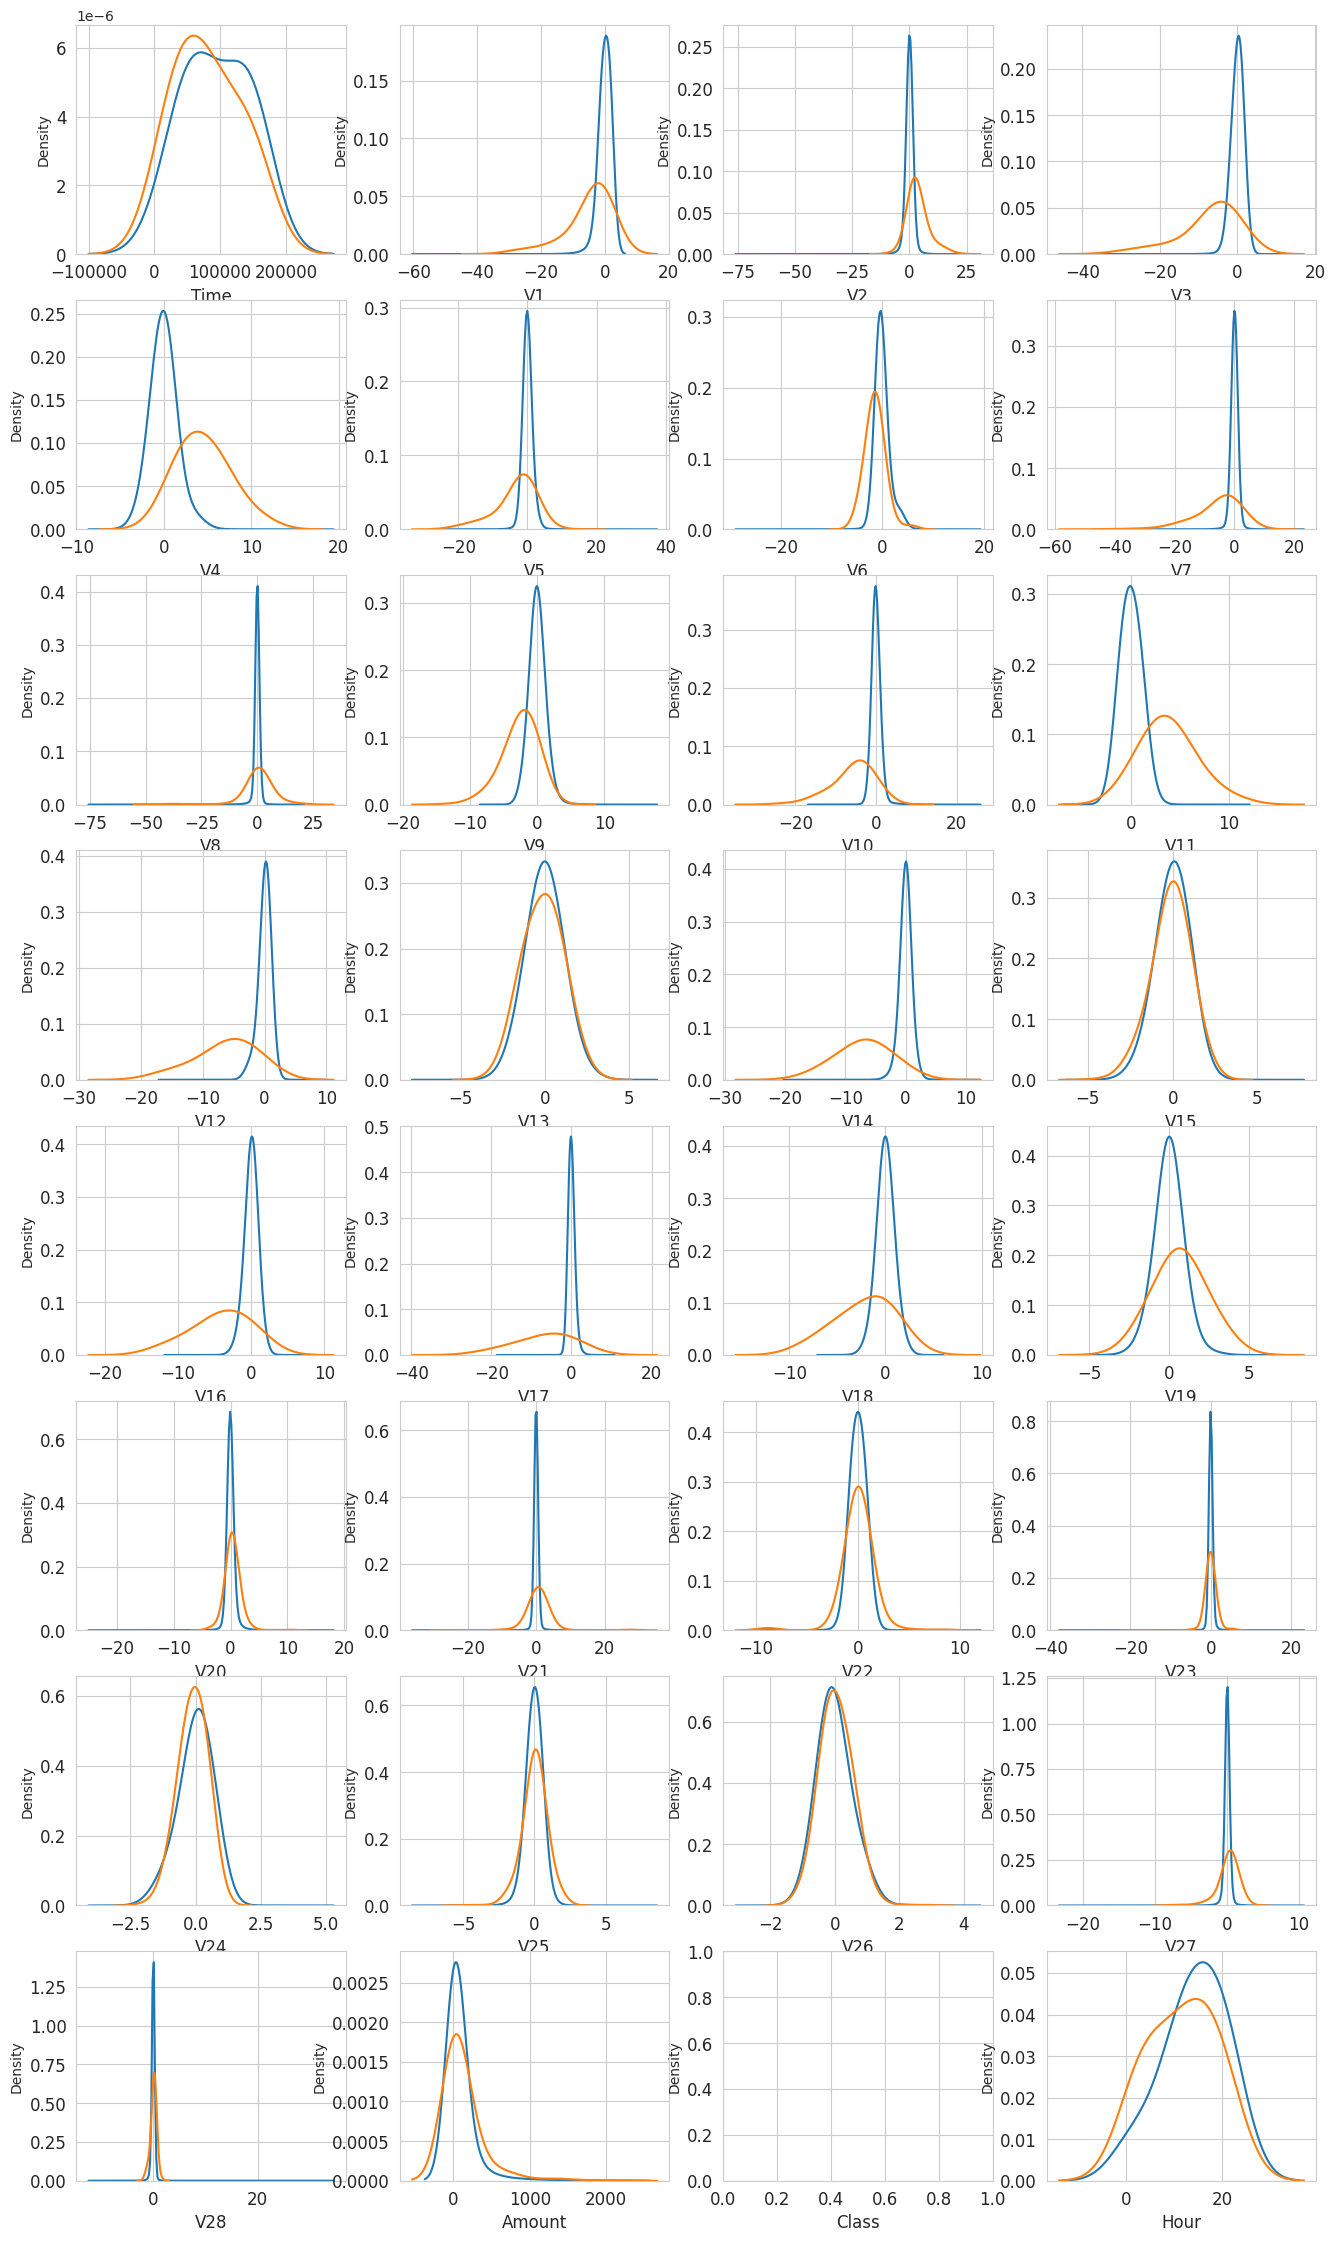

In [78]:
def plot_kde_plots(data, features):

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(8, 4, figsize=(16, 28))

    for i, feature in enumerate(features):
        plt.subplot(8, 4, i + 1)
        sns.kdeplot(data_major[feature], bw_method=0.7, label="Class = 0")
        sns.kdeplot(data_minor[feature], bw_method=0.7, label="Class = 1")
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show()

all_features = data.columns.values
plot_kde_plots(data, all_features)

Очень близкие или почти одинаковые распределения видим у признаков Time, Amount, V13, V15, V22, V24, V25, V26. Убираем их.

In [79]:
data_final = data.drop(['V13', 'V15', 'V22', 'V24', 'V25', 'V26', 'Time',\
                        'Amount'], axis = 1)

In [80]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 283178 entries, 0 to 281674
Data columns (total 24 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      283178 non-null  float64
 1   V2      283178 non-null  float64
 2   V3      283178 non-null  float64
 3   V4      283178 non-null  float64
 4   V5      283178 non-null  float64
 5   V6      283178 non-null  float64
 6   V7      283178 non-null  float64
 7   V8      283178 non-null  float64
 8   V9      283178 non-null  float64
 9   V10     283178 non-null  float64
 10  V11     283178 non-null  float64
 11  V12     283178 non-null  float64
 12  V14     283178 non-null  float64
 13  V16     283178 non-null  float64
 14  V17     283178 non-null  float64
 15  V18     283178 non-null  float64
 16  V19     283178 non-null  float64
 17  V20     283178 non-null  float64
 18  V21     283178 non-null  float64
 19  V23     283178 non-null  float64
 20  V27     283178 non-null  float64
 21  V28     283178 

***Выводы по корреляционному анализу:***

***1)*** Максимальная корреляция с целевым признаком - у признаков V12, V14, V17. Высокая корреляция у признаков V10, V11, V16, V18.

***2)*** Удалили исходный признак Time, имеющий сильную корреляцию с введенным нами признаком Hour. Удалили признаки Amount, V13, V15, V22, V24, V25, V26, распределение которых слабо различалось или вообще не различалось у мажорного и минорного классов.

##Шаг 5. Подготовка признаков для обучения модели.

Для балансировки данных наибольшей популярностью пользуется алгоритм SMOTE, который синтезирует новые экземпляры меньшинства между существующими экземплярами миноритарного класса. Недостаток данного подхода заключается в том, что «вслепую» увеличивает плотность объектами в области слабо представленного класса. В случае, если миноритарные объекты равномерно распределены среди мажоритарных и имеют низкую плотность, алгоритм SMOTE способен только сильнее перемешать классы.

Увеличение соотношения класса нелегитимных транзакций к классу легитимных требует больших вычислительных ресурсов, а также «засоряет» нелегитимный класс не всегда уместными «дублями». Это приведет к переобучению, а также к увеличению числа ошибок первого рода (False Positive, когда объект класса ноль ошибочно классифицируется как объект 1 класса, т е легитимную операцию классифицируют как мошенническую).

Уменьшение мажоритарного класса и, как следствие, соотношения класса легитимных транзакций, ведет к потере информации о легитимных операциях. Это тоже может привести к переобучению, а также к увеличению числа ошибок второго рода (False Negative, когда мошеннические транзакции ошибочно интерпретируются как легитимные). В данной задаче ошибки второго рода (False Negative) недопустимы: ошибка пропустить мошенническую транзакцию стОит дороже, чем ошибка квалифицировать легитимную операцию как мошенническую. В нашем случае стоИт задача свести в нулю или к минимально возможному порогу ошибки False Negative и максимизировать метрику recall, которая показывает, смогла ли модель классификации присвоить класс 1 всем объектам этого класса.

***Замечание:***
Для того чтобы выбрать модели, имеющие лучшие метрики качества на данных этой задачи, в начале используем пакет Lazypredict, созданный для ускорения процесса выбора и оценки модели в машинном обучении. Он автоматизирует построение и оценку нескольких моделей на заданном наборе данных, предлагая всеобъемлющий сводный отчет, демонстрирующий производительность каждой модели. Для обучения Lazypredict на полном наборе данных не хватает мощности компьютера, поэтому по этой причине придется урезать число объектов мажоритарного класса на этапе оценки моделей. Для обучения выбранных моделей будем использовать полный набор данных.

Есть два подхода: обучать модель на исходном объеме данных или перед обучением использовать методы, позволяющие нивелировать дисбаланс классов (undersampling или oversampling).
Предлагаю использовать оба подхода:
- в начале обучить модели на исходном датасете,
- затем обучить модели на датасете после применения алгоритма ADASYN (англ. Adaptive Synthetic — «Адаптивные синтетические наблюдения»). Он синтезирует данные на границе разделения классов и помогает модели лучше обучиться на пограничных примерах, делая границу более чёткой.

Сравним метрики моделей после обучения в разных вариантах и сделаем выводы.



План подготовки:

***1)*** Делим финальный датасет на два: объекты класса 0 (легитимные) и объекты класса 1 (мошеннические).

***2)*** Создадим копии датасетов для применения Lazypredict. Применим undersampling к копии датасета с легитимными операциями: сохраним 20% данных (при бОльшем объеме ОЗУ компьютера не справляется). Важно понимать, что при наличии мощностей обучать Lazypredict лучше на полном объеме данных.

***3)*** Соединим полученнную после undersampling копию мажорного датасета с копией минорнного датасета.

***4)*** Разделим полученные данные на тренировочную и тестовую выборки, сделав стратификацию по целевому признаку, чтобы соотношение классов в тестовой и тренировочной было одинаковым.

***5)*** Стандартизируем данные в тренировочной выброке.

***6)*** Применим метод Lazypredict, выберем лучшие модели, выберем и аргументируем метрики, которые нужно использовать для оценки качества моделей.

***7)*** Обучим лучшие модели на полном датасете.

Разделим датасет на два: с легитимными операциями и мошенническими.

In [81]:
data_final_major = data_final[data_final['Class'] == 0]

In [82]:
data_final_minor = data_final[data_final['Class'] == 1]

In [83]:
#Для обучения Lazypredict оставим в мажорном датасете 20% данных (56537 строк)
data_final_major_undersampled = data_final_major.sample(56537)

Объединим минорный датасет и мажорный после undersamling.

In [85]:
data_undersampled = pd.concat([data_final_major_undersampled, data_final_minor], axis = 0)
data_undersampled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 57029 entries, 239824 to 281674
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      57029 non-null  float64
 1   V2      57029 non-null  float64
 2   V3      57029 non-null  float64
 3   V4      57029 non-null  float64
 4   V5      57029 non-null  float64
 5   V6      57029 non-null  float64
 6   V7      57029 non-null  float64
 7   V8      57029 non-null  float64
 8   V9      57029 non-null  float64
 9   V10     57029 non-null  float64
 10  V11     57029 non-null  float64
 11  V12     57029 non-null  float64
 12  V14     57029 non-null  float64
 13  V16     57029 non-null  float64
 14  V17     57029 non-null  float64
 15  V18     57029 non-null  float64
 16  V19     57029 non-null  float64
 17  V20     57029 non-null  float64
 18  V21     57029 non-null  float64
 19  V23     57029 non-null  float64
 20  V27     57029 non-null  float64
 21  V28     57029 non-null  float64
 2

Разделим данные на тестовую и тренировочную.

In [86]:
features = data_undersampled.drop(columns = 'Class')
target = data_undersampled.Class

# разделение датасета на выборки с учётом дисбаланса
features_train, features_test, target_train, target_test = train_test_split(
    features,
    target,
    test_size = 0.25,
    random_state = 42,
    stratify = target
)

In [ ]:
# экземпляр сэмплера
#sampler = ADASYN(random_state = 42)

# сэмплируем данные
#features_train_resample, target_train_resample = sampler.fit_resample(features_train,\
                                                                      target_train)

Стандартизируем данные. Поскольку все признаки количественные, будем делать для всех признаков.

In [87]:
scaler = StandardScaler()
features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)

Для предварительной оценки качества моделей будем использовать инструмент lazypredict, который быстро строит и сравнивает модели машинного обучения без необходимости тратить время на изучение различных алгоритмов и оптимизацию гиперпараметров. По итогам модели ранжируются по значению метрик (по убыванию значения метрик).

In [88]:
clf = LazyClassifier(random_state=42)

# Fit the models using the downsampled training data and test on the original test set
models, predictions = clf.fit(features_train, features_test, target_train, target_test)

# Display the performance of the models
models

 97%|█████████▋| 28/29 [03:41<00:02,  2.95s/it]

[LightGBM] [Info] Number of positive: 369, number of negative: 42402
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5635
[LightGBM] [Info] Number of data points in the train set: 42771, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008627 -> initscore=-4.744154
[LightGBM] [Info] Start training from score -4.744154


100%|██████████| 29/29 [03:41<00:00,  7.65s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
PassiveAggressiveClassifier,1.00,0.93,0.93,1.00,0.08
LGBMClassifier,1.00,0.92,0.92,1.00,0.55
QuadraticDiscriminantAnalysis,0.97,0.92,0.92,0.98,0.12
XGBClassifier,1.00,0.92,0.92,1.00,0.47
DecisionTreeClassifier,1.00,0.92,0.92,1.00,2.15
BaggingClassifier,1.00,0.91,0.91,1.00,13.61
ExtraTreesClassifier,1.00,0.91,0.91,1.00,2.27
RandomForestClassifier,1.00,0.91,0.91,1.00,29.99
LogisticRegression,1.00,0.91,0.91,1.00,0.22


Самыми эффективными моделями оказались
- PassiveAgressive Classifier,
- Quadratic Discriminant Analysis,
- LGBM Classifier, XGBoost.
Обучим модели PassiveAgressive Classifier и XGBoost.

Важно отметить, что в задачах с сильным дисбалансом оценка accuracy не показательна. Показательной в данной задаче является метрика recall: сколько объектов класса 1 были классифицированы правильно (как объекты класса 1). В идеале нам нужна метрика recall 100%,  чтобы ни один объект класса 1 (мошеннические операции) не был классифицирован как объект класса 0 (легитимные операции).

Вторая показательная метрика - площадь под кривой Precision-Recall (Area Under the Precision-Recall Curve (AUPRC)).

Обучим выбранные с помощью LazyClassifier ТОП-3 модели и посчитаем указанные метрики.

Перед обучением моделей подготовим данные. Возьмем полный, не урезанный датасет (datafinal), разделим на тренировочную и тестовую выборки, сделав стратификацию по целевому признаку. Далее стандартизируем тренировочную выборку.

In [106]:
features_full = data_final.drop(columns = 'Class')
target_full = data_final.Class

# разделение датасета на выборки с учётом дисбаланса
features_train, features_test, target_train, target_test = train_test_split(
    features_full,
    target_full,
    test_size = 0.25,
    random_state = 42,
    stratify = target_full
)

Стандартизируем данные:

In [107]:
scaler = StandardScaler()
features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)

Обучим модель PassiveAgressiveClassifier.

In [108]:
from sklearn.linear_model import PassiveAggressiveClassifier
params = {"C":[0.5, 0.75, 1],
"validation_fraction":[0.1, 0.5, 0.75]}

pac = PassiveAggressiveClassifier(max_iter=50)
model_rs = RandomizedSearchCV(pac, param_distributions = params, cv=3, scoring = "recall_samples")
model_rs.fit(features_train,target_train)
print(model_rs.best_params_)


{'validation_fraction': 0.1, 'C': 0.5}


In [109]:
pac_predict = model_rs.predict(features_test)
print('Recall_pac:', round(recall_score(target_test, pac_predict), 2))

Recall_pac: 0.7


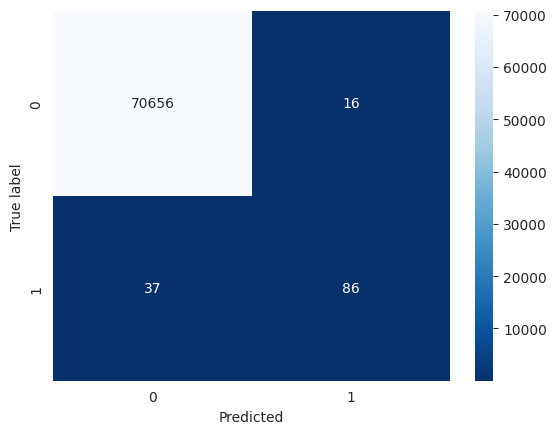

In [110]:
Pac_matrix = confusion_matrix(target_test, pac_predict)
sns.heatmap(Pac_matrix, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted');

Модель PassiveAgressive Classifier дала метрику recall всего 70% на исходных данных. Т е только 70% мошеннических транзакций классифицируются правильным образом, 30% модель не замечает.

Обучим модель XGBoost.

In [111]:
from sklearn.model_selection import RandomizedSearchCV
params = {"subsample":[0.5, 0.75, 1],
"colsample_bytree":[0.5, 0.75, 1],
"max_depth":[2, 6, 12],
"min_child_weight":[1,5,15],
"learning_rate":[0.3, 0.1, 0.03],
"n_estimators":[100]}

In [113]:
xgb_model = xgb.XGBClassifier(n_estimators=100, n_jobs=-1)

model_xgb_rs = RandomizedSearchCV(xgb_model, param_distributions = params, cv=3, scoring = "recall_samples")
#Fit the model as done previously
model_xgb_rs.fit(features_train,target_train)
print(model_xgb_rs.best_params_)

{'subsample': 0.5, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 12, 'learning_rate': 0.03, 'colsample_bytree': 0.5}


In [114]:
xgb_predict = model_xgb_rs.predict(features_test)
print('Recall:', round(recall_score(target_test, xgb_predict), 2))

Recall: 0.77


Построим Confusion Matrix.

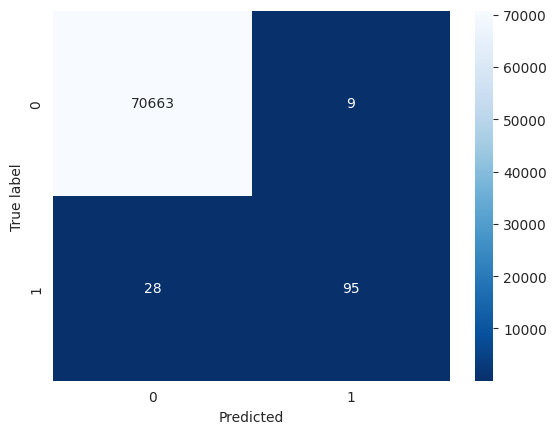

In [115]:
XGBoost_matrix = confusion_matrix(target_test, xgb_predict)
sns.heatmap(XGBoost_matrix, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted');

По итогу обучения модели XGBoost мы получили метрику recall 77%: 77% мошеннических транзакций (95 из 123 в данной задаче) классифицируются моделью XGBoost как мошеннические. Но 23% мошеннических транзакций (28 из 123) модель все же упускает.
Метрика низкая.



Теперь обучим те же модели на данных после ресемплирования, используем ADASYN.

In [116]:
# экземпляр сэмплера
sampler = ADASYN(random_state = 42)

# сэмплируем данные
features_train_resample, target_train_resample = sampler.fit_resample(features_train,\
                                                                      target_train)

Обучением модели PassiveAgressiveClassifier на данных после использования алгоритма ADASYN.

In [117]:
model_rs.fit(features_train_resample, target_train_resample)
print(model_rs.best_params_)

{'validation_fraction': 0.1, 'C': 0.5}


In [118]:
pac_predict_resample = model_rs.predict(features_test)
print('Recall_xgb_resample:', round(recall_score(target_test, pac_predict_resample), 2))

Recall_xgb_resample: 0.93


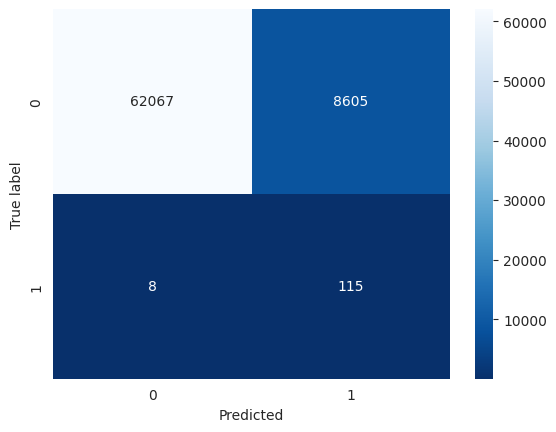

In [119]:
PAC_matrix = confusion_matrix(target_test, pac_predict_resample)
sns.heatmap(PAC_matrix, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted');

После использования ADASYN метрика у модели PassiveAgressive Classifier значительно выросла до 93%: 93% мошеннических транзакций (115 из 123) модель PAC классифицирует как мошеннические, 7% (8 из 123) модель пропускает. Это уже хороший результат.

Обучим модель XGBoost после ADASYN

In [ ]:
model_xgb_rs.fit(features_train_resample,target_train_resample)

In [122]:
xgb_predict = model_xgb_rs.predict(features_test)
print('Recall_XGB:', round(recall_score(target_test, xgb_predict), 2))

Recall_XGB: 0.77


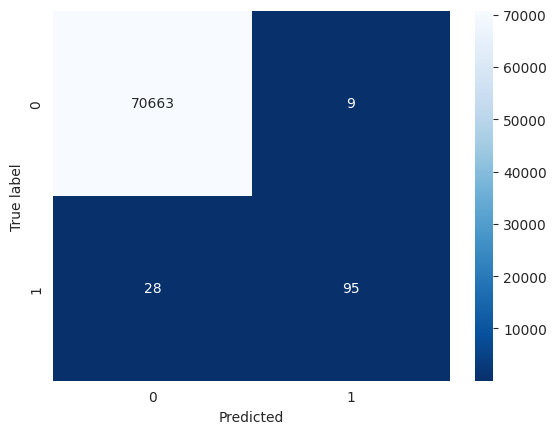

In [123]:
XGBoost_matrix = confusion_matrix(target_test, xgb_predict)
sns.heatmap(XGBoost_matrix, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted');

Метрика recall у модели XGBoost не изменилась (77%).

**Выводы по работе:**

***1)*** Лучшими моделями для выявления мошеннических транзакций по итогам использования пакета LazyClassifier стали PassiveAgressive Classifier, XGBoost, LGBN Classifier и QuadraticDiscriminantAnalysis.

***2)*** Я выбрала для обучения 2 модели: PassiveAgressive Classifier и XGBoost. В качестве метрики для определения качества моделей выбрали метрику recall, чтобы понять, какую долю объектов класса 1 (мошеннических транзакций) модели классифицируют верно (как мошенические транзакции).

***3)*** Обучила модели на исходном наборе данных, получила метрики recall 70% (PassiveAgressive Classifier) и 77% (XGBoost).

***4)*** После применения алгоритма ADASYN метрика модели XGBoost не изменилась, а у модели PassiveAgressive Classifier метрика recall выросла до 93%.

***5)*** На данном этапе можно рекомендовать модель PassiveAgressive Classifier для выявления мошеннических транзакций, предварительно применив алгоритм ADASYN к тренировочным выборкам исходного датасета.

***Замечание:***
В данной работе для применения LazyClassifier пришлось урезать часть исходного датасета (легитимные транзакции) на 80%, т к при бОльшем объеме датасета сервисы не справлялись, и применить LazyClassifier не представлялось возможным. Можно улучшить результат, если применить LazyClassifier к полному датасету при наличии бОльшего объема оперативной памяти. Тогда, возможно, будут выбраны другие модели, которые при обучении могут дать более высокие метрики.